In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from utils.load_data import load_data
from utils.preprocessing import preprocess_data
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchvision import datasets, transforms

%reload_ext autoreload
%autoreload 2

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [2]:
data = load_data()
X, y, countries, y_mean, y_std = preprocess_data(data=data, epsilon=EPS)
X.shape, y.shape

((550, 102), (550,))

In [3]:
X.head()

,date,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,...,Artificial_intelligence_average,International_Financial_Reporting_Standards_average,Employment_average,country_Canada,country_Germany,country_Japan,country_Korea,country_Switzerland,country_United Kingdom,country_United States
616,-1.771126,-1.060998,2.871241,-1.696290,1.582391,-0.732737,-0.290201,-0.604001,-0.078562,0.186376,...,-0.395035,-1.710910,1.689417,2.404079,-0.415203,-0.365755,-0.412193,-0.415203,-0.415203,-0.415203
6646,-1.771126,-0.036149,3.231815,0.589877,1.653900,-0.682008,1.399695,0.082269,1.703260,0.763066,...,-0.453614,-0.598496,1.689417,-0.415203,-0.415203,-0.365755,-0.412193,-0.415203,-0.415203,2.404079
6173,-1.771126,-1.009755,2.751050,-1.696290,1.718909,-1.037115,-0.773029,1.073548,2.594171,2.276877,...,-0.277877,0.745672,2.102636,-0.415203,-0.415203,-0.365755,-0.412193,-0.415203,2.404079,-0.415203
3645,-1.771126,-0.446089,2.210188,-1.696290,0.516251,0.636960,0.313333,-0.604001,0.875986,3.790689,...,-0.336456,-1.710910,1.839678,-0.415203,-0.415203,-0.365755,2.421635,-0.415203,-0.415203,-0.415203
5892,-1.771126,2.782184,-2.417180,-1.696290,1.426370,-1.290762,1.327271,-0.604001,2.530535,-3.273765,...,-0.043561,-1.710910,0.900544,-0.415203,-0.415203,-0.365755,-0.412193,2.404079,-0.415203,-0.415203


In [4]:
countries

616             Canada
6646     United States
6173    United Kingdom
3645             Korea
5892       Switzerland
             ...      
856             Canada
6413    United Kingdom
2588           Germany
6132       Switzerland
6886     United States
Name: country, Length: 550, dtype: object

## Simple Prediction Model

### We start with a simple regression model

In [5]:
percent_train = 0.9
number_train = int(len(X) * percent_train)

In [6]:
x_values = X.values
y_values = y.values

# Add previous GDP as input
x_values = np.hstack([x_values[1:], y_values[:-1][:, None], x_values[:-1]])
y_values = y_values[1:]

In [7]:
x_train = X.values[:number_train, :]
y_train = y.values[:number_train]
x_valid = X.values[number_train:, :]
y_valid = y.values[number_train:]
country_train = countries.values[:number_train]
country_valid = countries.values[number_train:]

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [9]:
def spectral_norm(module, lip):
    if isinstance(module, nn.Linear):
        with torch.no_grad():
            # Compute the largest singular value (spectral norm) of the weight matrix
            sigma = torch.linalg.norm(module.weight, ord=2)
            # Scale the weight matrix to have spectral norm equal to 'lip'
            if sigma > EPS:
                scaling_factor = lip / sigma
                module.weight.mul_(scaling_factor)

def enforce_lipschitz(model, lip):
    model.apply(lambda x: spectral_norm(x, lip))

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
def train_nn(x_train, y_train, x_valid, y_valid, num_epochs=1000, learning_rate=1e-3, weight_decay=1e-5, lipschitz=None):
    num_features = x_train.shape[1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)
    
    for t in tqdm(range(num_epochs)):
        model.train()
        y_pred = model(x_train_t)
        loss = loss_fn(y_pred, y_train_t)
        if t % 500 == 499:
            print(t, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if lipschitz is not None:
            enforce_lipschitz(model, lipschitz)
        
    model.eval()
    y_pred = model(x_valid_t)
    loss = loss_fn(y_pred, y_valid_t)
    print(f"Validation loss: {loss.item()}")
    
    return model, loss.item(), y_pred

In [11]:
def smoothness_measure(sequence, real_sequence):
    with torch.no_grad():
        diff_diff = torch.diff(sequence.squeeze()) - torch.diff(real_sequence.squeeze())
        return (torch.linalg.norm(diff_diff) / diff_diff.shape[0]).clone().detach().cpu().numpy()

In [12]:
y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)
losses = []

parameter_space = np.linspace(1e-1, 1, 30)
for l in parameter_space:
    model, loss, y_pred = train_nn(x_train, y_train, x_valid, y_valid, num_epochs=1000, learning_rate=1e-3, weight_decay=1e-5, lipschitz=l)

    smoothness = smoothness_measure(y_pred, y_valid_t)

    print(f"Lipschitz: {l}, Loss: {loss}, Smoothness: {smoothness}")
    losses.append({'lip': l, 'loss': loss, 'model': model, 'smoothness': smoothness})

  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.6938438415527344
999 0.6938463449478149
Validation loss: 3.9696576595306396
Lipschitz: 0.1, Loss: 3.9696576595306396, Smoothness: 0.22001603245735168


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.6889550089836121
999 0.6890747547149658
Validation loss: 3.9523403644561768
Lipschitz: 0.1310344827586207, Loss: 3.9523403644561768, Smoothness: 0.21979844570159912


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.6814296841621399
999 0.6814320087432861
Validation loss: 3.919032573699951
Lipschitz: 0.16206896551724137, Loss: 3.919032573699951, Smoothness: 0.21945860981941223


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.6702209115028381
999 0.6702567934989929
Validation loss: 3.8670363426208496
Lipschitz: 0.19310344827586207, Loss: 3.8670363426208496, Smoothness: 0.2189461886882782


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.6558979153633118
999 0.6555478572845459
Validation loss: 3.817549228668213
Lipschitz: 0.22413793103448276, Loss: 3.817549228668213, Smoothness: 0.2184087038040161


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.6361547708511353
999 0.6361080408096313
Validation loss: 3.7333333492279053
Lipschitz: 0.25517241379310346, Loss: 3.7333333492279053, Smoothness: 0.2173955887556076


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.6138557195663452
999 0.6129181385040283
Validation loss: 3.640826940536499
Lipschitz: 0.28620689655172415, Loss: 3.640826940536499, Smoothness: 0.2166050672531128


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.5833852887153625
999 0.5840282440185547
Validation loss: 3.5028300285339355
Lipschitz: 0.3172413793103448, Loss: 3.5028300285339355, Smoothness: 0.21490509808063507


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.5503350496292114
999 0.5516889095306396
Validation loss: 3.3460326194763184
Lipschitz: 0.34827586206896555, Loss: 3.3460326194763184, Smoothness: 0.2131257802248001


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.5133172273635864
999 0.5146503448486328
Validation loss: 3.1759297847747803
Lipschitz: 0.3793103448275862, Loss: 3.1759297847747803, Smoothness: 0.21145294606685638


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.4702497124671936
999 0.47363635897636414
Validation loss: 3.008206844329834
Lipschitz: 0.41034482758620694, Loss: 3.008206844329834, Smoothness: 0.20935402810573578


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.4273970425128937
999 0.4297504723072052
Validation loss: 2.782963991165161
Lipschitz: 0.4413793103448276, Loss: 2.782963991165161, Smoothness: 0.20640762150287628


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.377456933259964
999 0.3814065456390381
Validation loss: 2.5280959606170654
Lipschitz: 0.4724137931034482, Loss: 2.5280959606170654, Smoothness: 0.20214036107063293


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.32897067070007324
999 0.33337023854255676
Validation loss: 2.3176069259643555
Lipschitz: 0.503448275862069, Loss: 2.3176069259643555, Smoothness: 0.197278693318367


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.27955037355422974
999 0.2801736295223236
Validation loss: 2.0511999130249023
Lipschitz: 0.5344827586206896, Loss: 2.0511999130249023, Smoothness: 0.18983326852321625


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.2423291653394699
999 0.2347564846277237
Validation loss: 1.7684015035629272
Lipschitz: 0.5655172413793104, Loss: 1.7684015035629272, Smoothness: 0.1812904328107834


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.18975208699703217
999 0.19093745946884155
Validation loss: 1.585155963897705
Lipschitz: 0.596551724137931, Loss: 1.585155963897705, Smoothness: 0.17256419360637665


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.15176992118358612
999 0.14822450280189514
Validation loss: 1.3807333707809448
Lipschitz: 0.6275862068965516, Loss: 1.3807333707809448, Smoothness: 0.1636301726102829


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.11269248276948929
999 0.10973865538835526
Validation loss: 1.1675922870635986
Lipschitz: 0.6586206896551724, Loss: 1.1675922870635986, Smoothness: 0.15235115587711334


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.08965488523244858
999 0.07816678285598755
Validation loss: 0.8369446992874146
Lipschitz: 0.689655172413793, Loss: 0.8369446992874146, Smoothness: 0.1359652727842331


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.0580921471118927
999 0.05291313678026199
Validation loss: 1.0003997087478638
Lipschitz: 0.7206896551724138, Loss: 1.0003997087478638, Smoothness: 0.15664036571979523


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.035502444952726364
999 0.02852722443640232
Validation loss: 0.7066702246665955
Lipschitz: 0.7517241379310344, Loss: 0.7066702246665955, Smoothness: 0.13578031957149506


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.017227673903107643
999 0.013735619373619556
Validation loss: 0.4035056233406067
Lipschitz: 0.7827586206896552, Loss: 0.4035056233406067, Smoothness: 0.10391920804977417


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.007934175431728363
999 0.006359557155519724
Validation loss: 0.32656317949295044
Lipschitz: 0.8137931034482758, Loss: 0.32656317949295044, Smoothness: 0.09032739698886871


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.0056771873496472836
999 0.0035577306989580393
Validation loss: 0.2982366681098938
Lipschitz: 0.8448275862068965, Loss: 0.2982366681098938, Smoothness: 0.09016982465982437


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.0038466942496597767
999 0.001762692234478891
Validation loss: 0.26788583397865295
Lipschitz: 0.8758620689655172, Loss: 0.26788583397865295, Smoothness: 0.08500557392835617


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.002387549262493849
999 0.0006035824189893901
Validation loss: 0.23379665613174438
Lipschitz: 0.9068965517241379, Loss: 0.23379665613174438, Smoothness: 0.07924755662679672


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.0014674527337774634
999 0.0003226481785532087
Validation loss: 0.2597920596599579
Lipschitz: 0.9379310344827586, Loss: 0.2597920596599579, Smoothness: 0.08105376362800598


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.0004441110650077462
999 6.14403179497458e-05
Validation loss: 0.32935622334480286
Lipschitz: 0.9689655172413792, Loss: 0.32935622334480286, Smoothness: 0.07957232743501663


  0%|          | 0/1000 [00:00<?, ?it/s]

499 0.0005246989312581718
999 7.54996290197596e-05
Validation loss: 0.26326826214790344
Lipschitz: 1.0, Loss: 0.26326826214790344, Smoothness: 0.07776450365781784


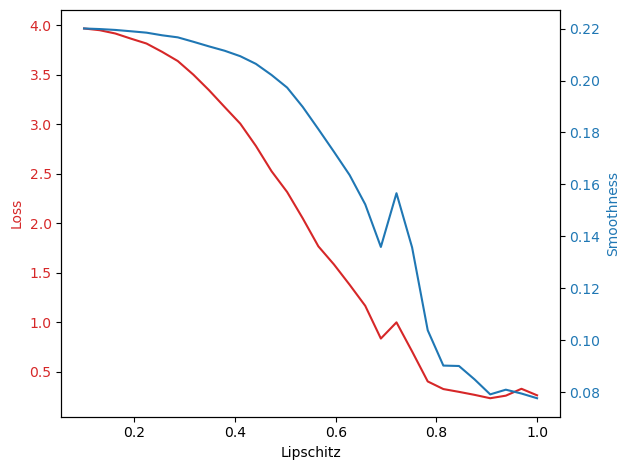

In [13]:
# Plot with different y axis
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Lipschitz')
ax1.set_ylabel('Loss', color=color)

ax1.plot([l['lip'] for l in losses], [l['loss'] for l in losses], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Smoothness', color=color)

ax2.plot([l['lip'] for l in losses], [l['smoothness'] for l in losses], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [14]:
parameter_space

array([0.1       , 0.13103448, 0.16206897, 0.19310345, 0.22413793,
       0.25517241, 0.2862069 , 0.31724138, 0.34827586, 0.37931034,
       0.41034483, 0.44137931, 0.47241379, 0.50344828, 0.53448276,
       0.56551724, 0.59655172, 0.62758621, 0.65862069, 0.68965517,
       0.72068966, 0.75172414, 0.78275862, 0.8137931 , 0.84482759,
       0.87586207, 0.90689655, 0.93793103, 0.96896552, 1.        ])

In [ ]:
smallest_smoothness = np.argmin([l['smoothness'] for l in losses])
smallest_loss = np.argmin([l['loss'] for l in losses])

print(f"Smallest smoothness: {losses[smallest_smoothness]}")
print(f"Smallest loss: {losses[smallest_loss]}")

model = losses[smallest_loss]['model']

Smallest smoothness: {'lip': 1.0, 'loss': 0.26326826214790344, 'model': NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=102, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
), 'smoothness': array(0.0777645, dtype=float32)}
Smallest loss: {'lip': 0.9068965517241379, 'loss': 0.23379665613174438, 'model': NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=102, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
), 'smoothness': array(0.07924756, dtype=float32)}


In [ ]:
model = losses[0]['model']

# Get the predictions
x_valid = torch.tensor(x_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)

y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

C:\Users\sebge\AppData\Local\Temp\ipykernel_21656\2926180580.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_valid = torch.tensor(x_valid, dtype=torch.float32).to(device)
C:\Users\sebge\AppData\Local\Temp\ipykernel_21656\2926180580.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)


In [49]:
# Associate the result by country
y_pred_country = pd.DataFrame({'date': X['date'][number_train:], 'country': country_valid, 'y_pred': y_pred, 'y_true': y_valid})
y_pred_train_country = pd.DataFrame({'date': X['date'][:number_train], 'country': country_train, 'y_pred': y_pred_train, 'y_true': y_train})
y_pred_train_country

,date,country,y_pred,y_true
616,-1.771126,Canada,-0.170993,-1.110615
6646,-1.771126,United States,-0.166753,-0.539413
6173,-1.771126,United Kingdom,-0.171717,-1.228650
3645,-1.771126,Korea,-0.172053,-1.837559
5892,-1.771126,Switzerland,-0.171763,-0.636078
...,...,...,...,...
6389,1.366397,United Kingdom,-0.161483,0.582981
832,1.366397,Canada,-0.160488,0.938508
3527,1.366397,Japan,-0.162312,-0.146885
3861,1.366397,Korea,-0.165414,0.173998


In [50]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [51]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)



# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(percent_train)
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({percent_train}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'United States', 'United Kingdom', '…